## EECS 531 - E1 - A4
### Tristan Maidment (tdm47)

#### Goal
The purpose of this exercise is to estimate the optical flow in a sequence if images via template matching.  To determine the vector motion, a small kernel is matched with the surrounding area in the following frame.  By finding the location on the following frame with the highest correlation relative to the original patch area, we can estimate the motion of direction.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pims import ImageSequence
import skimage.measure
import math
from skimage.feature import match_template


We will be using the ImageSequence object provided by the pims API to store the images.

In [2]:
img_rubic = ImageSequence('./data/rubic/rubic.*.png', as_grey=True)
img_sphere = ImageSequence('./data/sphere/sphere.*.png', as_grey=True)

As explained earlier, to estimate the optical flow using a kernel, we will be matching a small section of the image with a local section of the following image.

##### Methodology
The first step is to pad both images to for the inclusion of the edge cases.  The algorithm simply selects points throughout the image where the motion should be estimated and selects a local region as the "kernel".  It then selects a slightly larger region in the subsequent frame, and finds the correlation between the two.  The location of the maximum response is the direction of the arrow.

In [3]:
## add variable kernel region
def optical_flow_field(img1, img2, kernel_size, grid_size):
    height, width = img1.shape
    
    grid_x, grid_y = grid_size[0], grid_size[1]
    ker_x, ker_y = kernel_size[0], kernel_size[1]
    
    pad_width_x, pad_width_y = np.divide((ker_x, ker_y), 2).astype(int)
    pad_size = np.asarray(((ker_x,ker_y), (ker_x,ker_y))).astype(int)
    
    img1_pad = np.pad(img1, pad_size, 'wrap')
    img2_pad = np.pad(img2, pad_size, 'wrap')
    
    flow = np.zeros((grid_x, grid_y, 2))
    delta_x, delta_y = int(height/grid_x), int(width/grid_y)
    
    i = np.arange(0, width, delta_x) + np.floor(delta_x/2)
    j = np.arange(0, height, delta_y) + np.floor(delta_y/2)
    gridX, gridY = np.meshgrid(i,j);
    
    for k in np.arange(0, grid_x):
        for l in np.arange(0, grid_y):
            x = (k*delta_x) + pad_width_x
            y = (l*delta_y) + pad_width_y
            res_kernel = img1_pad[x:x + ker_x, y:y + ker_y]
            response = match_template(img2_pad[x-pad_width_x:x+pad_width_x+ker_x, y-pad_width_y:y+pad_width_y+ker_y], res_kernel, 4)
            flow[k, l] = getDir(response, pad_width_x, pad_width_y)
    return (gridX, gridY), flow

To get the direction of the motion, we need to find the location in the following frame with the highest correlation to the first frame.  Using the response acquired by template matching, we can use the pixel location of the highest correlation as the motion vectors.  Due to the correlation being tested on a larger region than the kernel, the response is offset from the original kernals position.  For that reason, the direction must have that offset subtracted.  However, for regions with no motion flow, the motion vector will be equal to this offset, and should be set to 0.

In [4]:
def getDir(response, pad_width_x, pad_width_y):
    X, Y = np.multiply(response.max(), np.unravel_index(response.argmax(), response.shape))
    X -= pad_width_x
    Y -= pad_width_y
    return (X, Y) if X != Y else (0, 0)

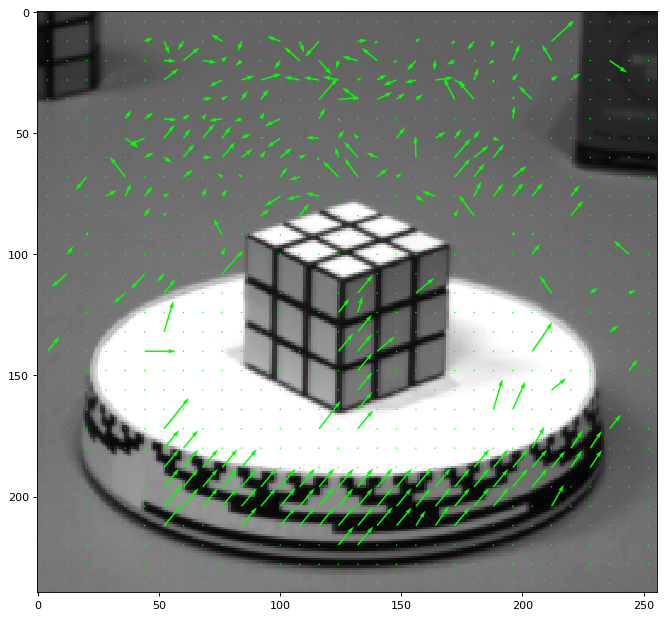

In [5]:
grid, flow = optical_flow_field(img_rubic[0]/255, img_rubic[1]/255, (10,10), (30, 32))
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_rubic[1], cmap='gray')
plt.quiver(grid[0], grid[1], flow[:,:,0], flow[:,:,1], color='lime', angles="uv", scale=200)
plt.show()

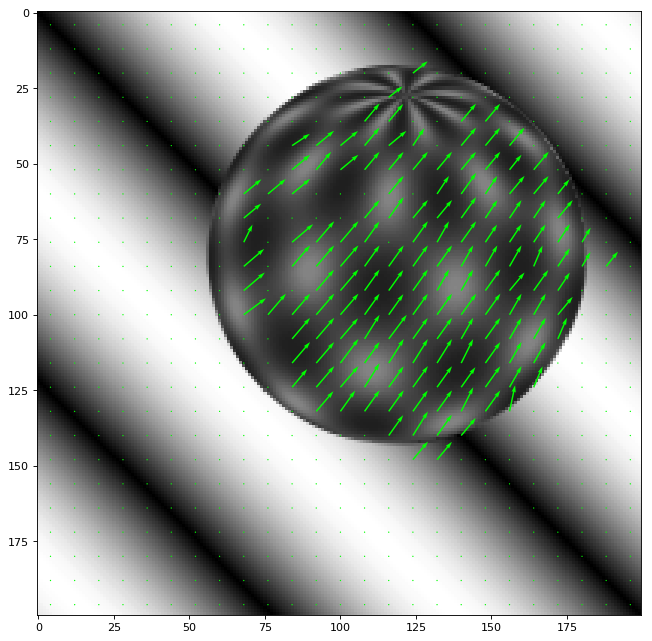

In [6]:
grid, flow = optical_flow_field(img_sphere[0]/255, img_sphere[1]/255, (10,10), (25, 25))
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_sphere[1], cmap='gray')
plt.quiver(grid[0], grid[1], flow[:,:,0], flow[:,:,1], color='lime', angles="uv", scale=200)
plt.show()

### Conclusion
Overall, this method is good for estimating optical flow for both images tested, but appears to be very sensitive to areas that have the overall intensity.  For instance, the area above the Rubic's Cube shows lots of optical flow, yet no optical flow exists.  This is most likely due to noise from compression.